In [1]:
# Step 1: Setup and imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

# Ensure reproducibility
np.random.seed(42)

print("Setup complete.")


Setup complete.


In [3]:
import pandas as pd

# Replace with your actual file name if different
df = pd.read_csv("/content/post_pandemic_remote_work_health_impact_2025.csv")

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (3157, 14)


,Survey_Date,Age,Gender,Region,Industry,Job_Role,Work_Arrangement,Hours_Per_Week,Mental_Health_Status,Burnout_Level,Work_Life_Balance_Score,Physical_Health_Issues,Social_Isolation_Score,Salary_Range
0,2025-06-01,27,Female,Asia,Professional Services,Data Analyst,Onsite,64,Stress Disorder,High,3,Shoulder Pain; Neck Pain,2,$40K-60K
1,2025-06-01,37,Female,Asia,Professional Services,Data Analyst,Onsite,37,Stress Disorder,High,4,Back Pain,2,$80K-100K
2,2025-06-01,32,Female,Africa,Education,Business Analyst,Onsite,36,ADHD,High,3,Shoulder Pain; Eye Strain,2,$80K-100K
3,2025-06-01,40,Female,Europe,Education,Data Analyst,Onsite,63,ADHD,Medium,1,Shoulder Pain; Eye Strain,2,$60K-80K
4,2025-06-01,30,Male,South America,Manufacturing,DevOps Engineer,Hybrid,65,NaN,Medium,5,NaN,4,$60K-80K


In [4]:
from sklearn.preprocessing import MinMaxScaler

# Make a copy
df_clean = df.copy()

# Target column
target_col = 'Burnout_Level'

# Numeric and categorical features
numeric_cols = ['Age','Hours_Per_Week','Work_Life_Balance_Score','Social_Isolation_Score']
categorical_cols = ['Gender','Region','Industry','Job_Role','Work_Arrangement',
                    'Mental_Health_Status','Physical_Health_Issues','Salary_Range']

# --- 2.1 Handle missing values (mode imputation for two columns) ---
for col in ['Mental_Health_Status','Physical_Health_Issues']:
    if col in df_clean.columns:
        mode_val = df_clean[col].mode()[0]
        df_clean[col] = df_clean[col].fillna(mode_val)

# --- 2.2 Encode target variable (Low=0, Medium=1, High=2) ---
target_map = {'Low':0, 'Medium':1, 'High':2}
df_clean[target_col] = df_clean[target_col].map(target_map)

# --- 2.3 One-Hot Encode categorical features ---
X_cat = pd.get_dummies(df_clean[categorical_cols], drop_first=False)

# --- 2.4 Scale numeric features ---
scaler = MinMaxScaler()
X_num = pd.DataFrame(scaler.fit_transform(df_clean[numeric_cols]),
                     columns=numeric_cols, index=df_clean.index)

# --- Final feature set ---
X = pd.concat([X_num, X_cat], axis=1)
y = df_clean[target_col]

print("Final shape:", X.shape, " Target shape:", y.shape)
X.head()


Final shape: (3157, 92)  Target shape: (3157,)


,Age,Hours_Per_Week,Work_Life_Balance_Score,Social_Isolation_Score,Gender_Female,Gender_Male,Gender_Non-binary,Gender_Prefer not to say,Region_Africa,Region_Asia,...,Physical_Health_Issues_Shoulder Pain; Eye Strain; Wrist Pain,Physical_Health_Issues_Shoulder Pain; Neck Pain,Physical_Health_Issues_Shoulder Pain; Neck Pain; Wrist Pain,Physical_Health_Issues_Shoulder Pain; Wrist Pain,Physical_Health_Issues_Wrist Pain,Salary_Range_$100K-120K,Salary_Range_$120K+,Salary_Range_$40K-60K,Salary_Range_$60K-80K,Salary_Range_$80K-100K
0,0.116279,0.966667,0.50,0.25,True,False,False,False,False,True,...,False,True,False,False,False,False,False,True,False,False
1,0.348837,0.066667,0.75,0.25,True,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
2,0.232558,0.033333,0.50,0.25,True,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
3,0.418605,0.933333,0.00,0.25,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,0.186047,1.000000,1.00,0.75,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


Correlation Heatmap (numeric features + target)

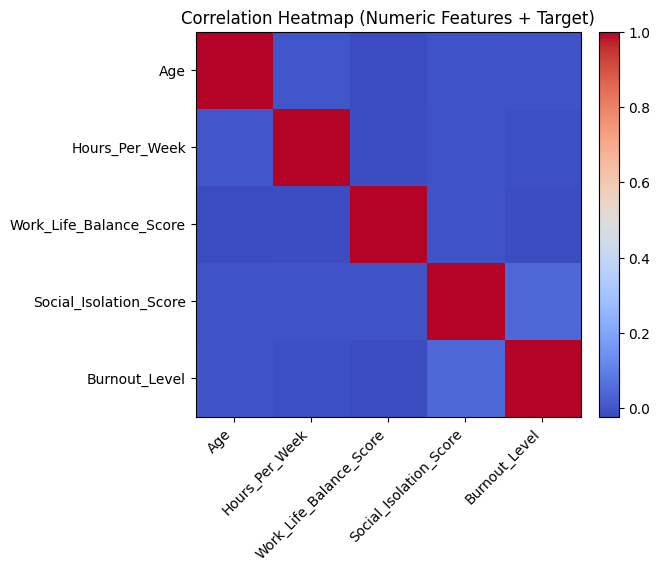

                           Age  Hours_Per_Week  Work_Life_Balance_Score  \
Age                      1.000           0.004                   -0.023   
Hours_Per_Week           0.004           1.000                   -0.015   
Work_Life_Balance_Score -0.023          -0.015                    1.000   
Social_Isolation_Score  -0.003          -0.004                   -0.005   
Burnout_Level           -0.001          -0.012                   -0.018   

                         Social_Isolation_Score  Burnout_Level  
Age                                      -0.003         -0.001  
Hours_Per_Week                           -0.004         -0.012  
Work_Life_Balance_Score                  -0.005         -0.018  
Social_Isolation_Score                    1.000          0.043  
Burnout_Level                             0.043          1.000  


In [5]:
import matplotlib.pyplot as plt

# Correlation between numeric features + target
corr_df = df_clean[numeric_cols + [target_col]]
corr = corr_df.corr()

plt.figure(figsize=(6,5))
im = plt.imshow(corr, cmap="coolwarm")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha='right')
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Correlation Heatmap (Numeric Features + Target)")
plt.show()

print(corr.round(3))


 Mutual Information (all features vs target)

                                            Feature  MI_Score
90                            Salary_Range_$60K-80K  0.024734
34                              Job_Role_HR Manager  0.023971
31            Job_Role_Digital Marketing Specialist  0.021475
83  Physical_Health_Issues_Shoulder Pain; Neck Pain  0.020848
0                                               Age  0.020362
32                     Job_Role_Executive Assistant  0.018405
44                       Job_Role_Software Engineer  0.018282
48                          Work_Arrangement_Onsite  0.014741
28                            Job_Role_Data Analyst  0.013990
35                              Job_Role_IT Support  0.013261
49                          Work_Arrangement_Remote  0.013182
55             Mental_Health_Status_Stress Disorder  0.013017
56                 Physical_Health_Issues_Back Pain  0.011149
91                           Salary_Range_$80K-100K  0.010367
11                             Region_North America  0.010161


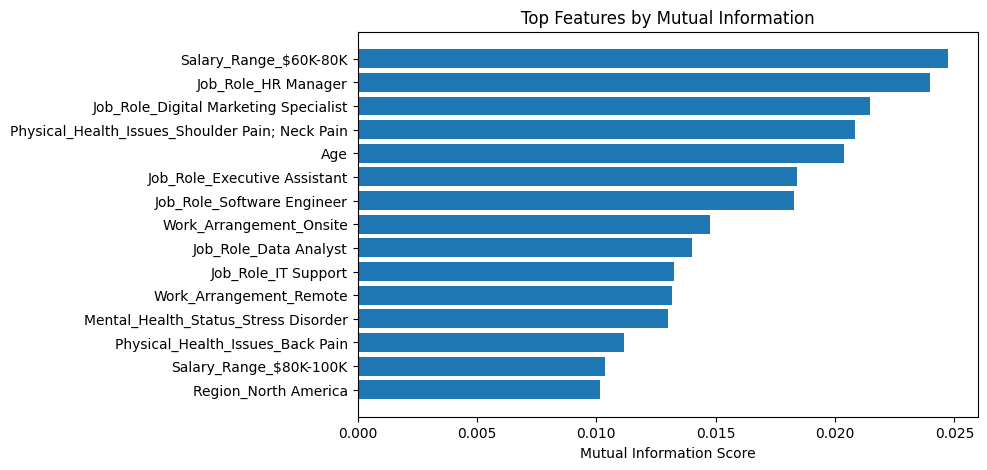

In [6]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

# Compute mutual information
mi_scores = mutual_info_classif(X, y, discrete_features='auto')
mi_df = pd.DataFrame({"Feature": X.columns, "MI_Score": mi_scores})
mi_df = mi_df.sort_values("MI_Score", ascending=False)

# Show top 15
print(mi_df.head(15))

# Plot top 15
top_k = 15
plt.figure(figsize=(8,5))
plt.barh(mi_df["Feature"].head(top_k)[::-1], mi_df["MI_Score"].head(top_k)[::-1])
plt.xlabel("Mutual Information Score")
plt.title("Top Features by Mutual Information")
plt.show()


Filter Method – Correlation + Mutual Information

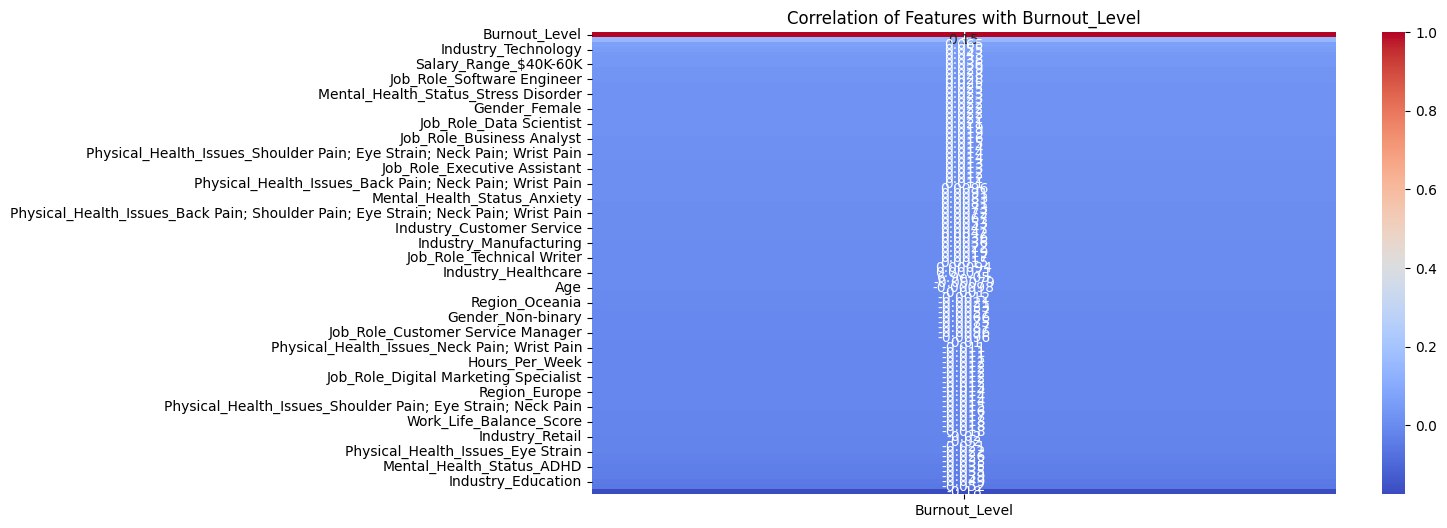

Top 10 features (Mutual Information): ['Region_Oceania', 'Industry_Technology', 'Job_Role_Customer Service Manager', 'Job_Role_HR Manager', 'Job_Role_Operations Manager', 'Job_Role_Product Manager', 'Work_Arrangement_Hybrid', 'Physical_Health_Issues_Eye Strain; Wrist Pain', 'Physical_Health_Issues_Neck Pain', 'Salary_Range_$100K-120K']


In [11]:
import seaborn as sns

# Correlation with target
corr_matrix = X.join(y).corr()
target_corr = corr_matrix[target_col].sort_values(ascending=False)

# Plot correlation heatmap
plt.figure(figsize=(12,6))
sns.heatmap(target_corr.to_frame(), annot=True, cmap='coolwarm')
plt.title("Correlation of Features with Burnout_Level")
plt.show()

# Mutual Information
from sklearn.feature_selection import SelectKBest, mutual_info_classif

mi = SelectKBest(score_func=mutual_info_classif, k=10)
mi.fit(X, y)
mi_features = X.columns[mi.get_support()]
print("Top 10 features (Mutual Information):", list(mi_features))


Wrapper Method – Recursive Feature Elimination (RFE)

In [17]:
# RFE with Logistic Regression
model = LogisticRegression(max_iter=1000)
rfe = RFE(model, n_features_to_select=10)
rfe.fit(X, y)
rfe_features = X.columns[rfe.support_]
print("Top 10 features (RFE):", list(rfe_features))


Top 10 features (RFE): ['Gender_Prefer not to say', 'Job_Role_Account Manager', 'Work_Arrangement_Onsite', 'Physical_Health_Issues_Back Pain; Eye Strain; Neck Pain; Wrist Pain', 'Physical_Health_Issues_Back Pain; Neck Pain; Wrist Pain', 'Physical_Health_Issues_Back Pain; Shoulder Pain; Eye Strain; Neck Pain; Wrist Pain', 'Physical_Health_Issues_Back Pain; Shoulder Pain; Neck Pain', 'Physical_Health_Issues_Eye Strain; Neck Pain; Wrist Pain', 'Physical_Health_Issues_Shoulder Pain; Eye Strain; Neck Pain; Wrist Pain', 'Physical_Health_Issues_Shoulder Pain; Eye Strain; Wrist Pain']


Embedded Method – Random Forest Feature Importance

Top 10 features (Random Forest): ['Age', 'Hours_Per_Week', 'Social_Isolation_Score', 'Work_Life_Balance_Score', 'Mental_Health_Status_PTSD', 'Salary_Range_$80K-100K', 'Gender_Male', 'Gender_Female', 'Salary_Range_$60K-80K', 'Industry_Professional Services']


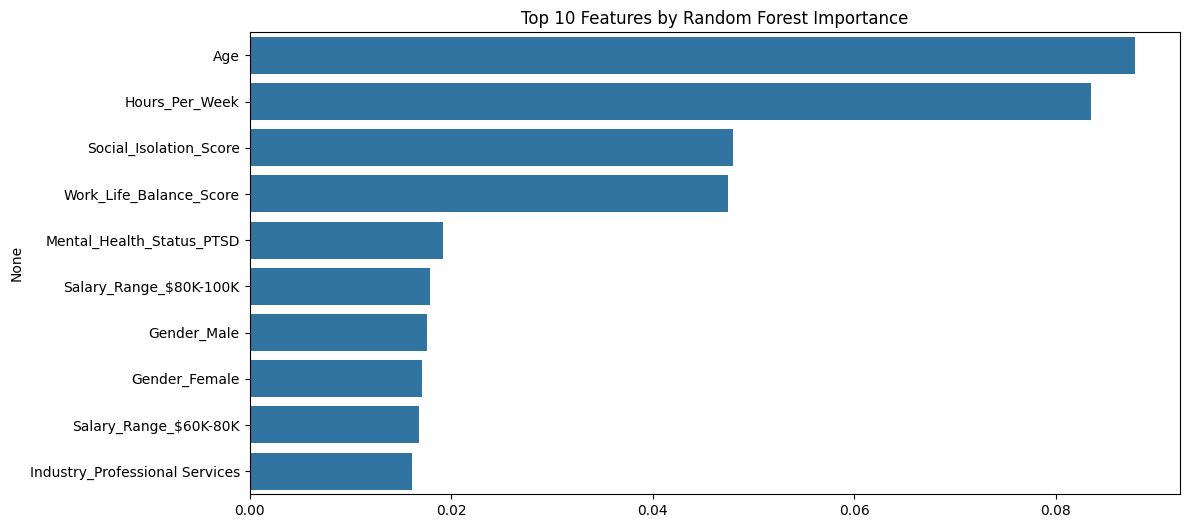

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Top 10 features by importance
top_rf_features = importances.head(10).index
print("Top 10 features (Random Forest):", list(top_rf_features))

# Optional plot
plt.figure(figsize=(12,6))
sns.barplot(x=importances.head(10).values, y=importances.head(10).index)
plt.title("Top 10 Features by Random Forest Importance")
plt.show()


Further analysis in feature importance

In [16]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X, y)

coef = pd.Series(np.abs(lr.coef_).sum(axis=0), index=X.columns).sort_values(ascending=False)
print("Top 20 features by absolute logistic regression coefficients:\n")
print(coef.head(20))


Top 20 features by absolute logistic regression coefficients:

Physical_Health_Issues_Back Pain; Shoulder Pain; Neck Pain                            1.030503
Physical_Health_Issues_Back Pain; Neck Pain; Wrist Pain                               1.013133
Physical_Health_Issues_Shoulder Pain; Eye Strain; Neck Pain; Wrist Pain               0.871990
Physical_Health_Issues_Eye Strain; Neck Pain; Wrist Pain                              0.816453
Work_Arrangement_Remote                                                               0.815202
Physical_Health_Issues_Back Pain; Shoulder Pain; Eye Strain; Neck Pain; Wrist Pain    0.726875
Physical_Health_Issues_Eye Strain; Wrist Pain                                         0.697062
Physical_Health_Issues_Wrist Pain                                                     0.692132
Physical_Health_Issues_Shoulder Pain; Eye Strain; Wrist Pain                          0.683378
Physical_Health_Issues_Back Pain; Eye Strain; Neck Pain; Wrist Pain               

Top 20 features by importance:

Age                                                 0.087900
Hours_Per_Week                                      0.083520
Social_Isolation_Score                              0.047962
Work_Life_Balance_Score                             0.047444
Mental_Health_Status_PTSD                           0.019156
Salary_Range_$80K-100K                              0.017960
Gender_Male                                         0.017662
Gender_Female                                       0.017129
Salary_Range_$60K-80K                               0.016858
Industry_Professional Services                      0.016115
Physical_Health_Issues_Shoulder Pain; Eye Strain    0.015382
Region_South America                                0.014885
Region_Asia                                         0.014812
Region_North America                                0.014757
Region_Oceania                                      0.014532
Region_Africa                                       0

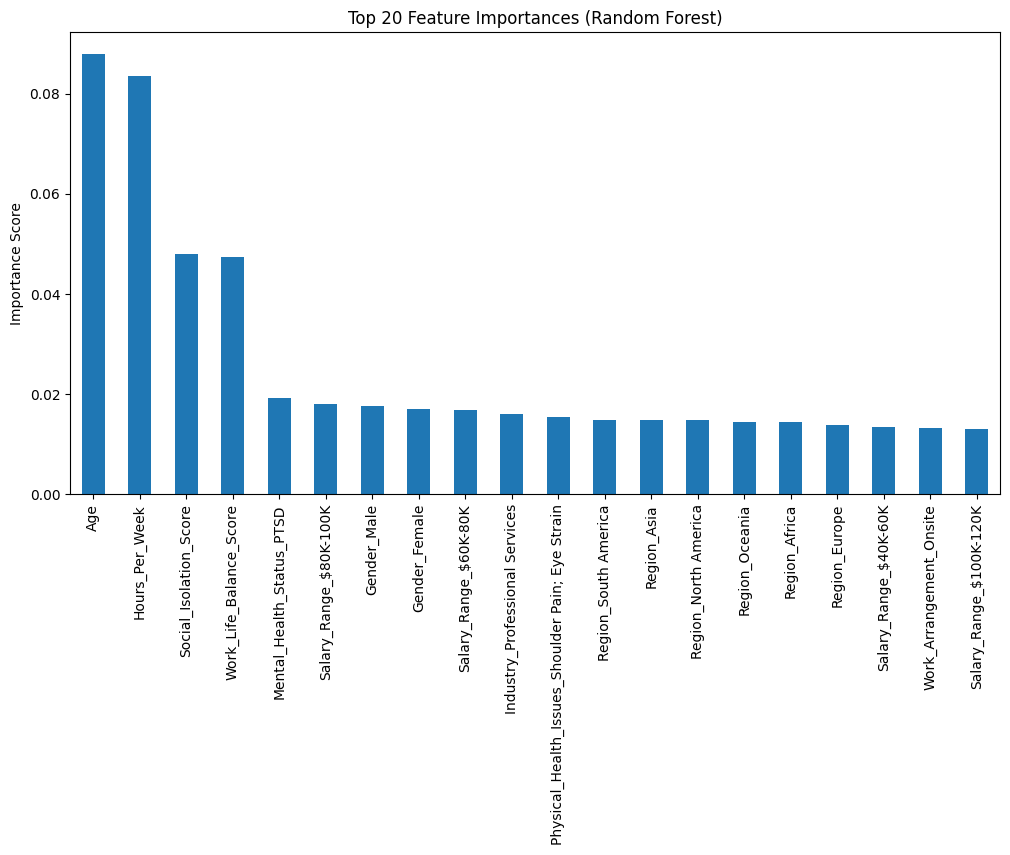

In [14]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Fit Random Forest on full data
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

# Get feature importances
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Display top 20 for clarity
print("Top 20 features by importance:\n")
print(importances.head(20))

# Optional: visualize
plt.figure(figsize=(12,6))
importances.head(20).plot(kind='bar')
plt.title("Top 20 Feature Importances (Random Forest)")
plt.ylabel("Importance Score")
plt.show()


In [15]:
# Group importance by original categorical feature
cat_features = ['Gender', 'Region', 'Industry', 'Job_Role', 'Work_Arrangement',
                'Mental_Health_Status', 'Physical_Health_Issues', 'Salary_Range']

for cat in cat_features:
    cat_cols = [c for c in X.columns if c.startswith(cat+'_')]
    total_importance = importances[cat_cols].sum()
    print(f"{cat}: total importance = {total_importance:.4f}")


Gender: total importance = 0.0415
Region: total importance = 0.0873
Industry: total importance = 0.0952
Job_Role: total importance = 0.1709
Work_Arrangement: total importance = 0.0325
Mental_Health_Status: total importance = 0.0800
Physical_Health_Issues: total importance = 0.1561
Salary_Range: total importance = 0.0696


Impact on Model

=== Model Performance Comparison ===
            Model  Accuracy  F1_Score
0     LogReg_Full  0.393987  0.349000
1  LogReg_Reduced  0.382911  0.213167
2         RF_Full  0.365506  0.312239
3      RF_Reduced  0.363924  0.353011


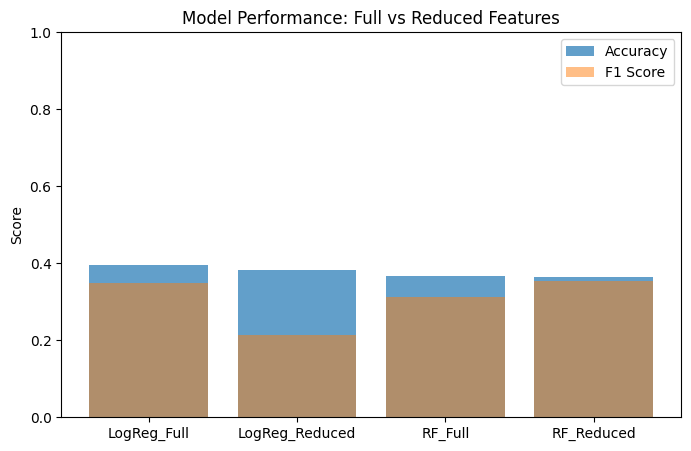

In [12]:
# --- 1. Define Final Reduced Feature Subset ---
final_features = [
    'Age',
    'Hours_Per_Week',
    'Work_Life_Balance_Score',
    'Social_Isolation_Score',
    'Mental_Health_Status_PTSD',
    'Physical_Health_Issues_Back Pain; Eye Strain; Neck Pain; Wrist Pain',
    'Job_Role_Account Manager',
    'Salary_Range_$80K-100K'
]

# --- 2. Train/Test Split (80% train, 20% test) ---
from sklearn.model_selection import train_test_split

X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_red, X_test_red = X_train_full[final_features], X_test_full[final_features]

# --- 3. Import Models & Metrics ---
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

# --- 4. Logistic Regression ---
lr = LogisticRegression(max_iter=1000, random_state=42)

# Full features
lr.fit(X_train_full, y_train)
y_pred_lr_full = lr.predict(X_test_full)

# Reduced features
lr.fit(X_train_red, y_train)
y_pred_lr_red = lr.predict(X_test_red)

# --- 5. Random Forest ---
rf = RandomForestClassifier(random_state=42)

# Full features
rf.fit(X_train_full, y_train)
y_pred_rf_full = rf.predict(X_test_full)

# Reduced features
rf.fit(X_train_red, y_train)
y_pred_rf_red = rf.predict(X_test_red)

# --- 6. Evaluate Performance ---
import pandas as pd

results = pd.DataFrame({
    'Model': ['LogReg_Full','LogReg_Reduced','RF_Full','RF_Reduced'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr_full),
        accuracy_score(y_test, y_pred_lr_red),
        accuracy_score(y_test, y_pred_rf_full),
        accuracy_score(y_test, y_pred_rf_red)
    ],
    'F1_Score': [
        f1_score(y_test, y_pred_lr_full, average='weighted'),
        f1_score(y_test, y_pred_lr_red, average='weighted'),
        f1_score(y_test, y_pred_rf_full, average='weighted'),
        f1_score(y_test, y_pred_rf_red, average='weighted')
    ]
})

print("=== Model Performance Comparison ===")
print(results)

# --- 7.Visualize Performance ---
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(results['Model'], results['Accuracy'], alpha=0.7, label='Accuracy')
plt.bar(results['Model'], results['F1_Score'], alpha=0.5, label='F1 Score')
plt.title("Model Performance: Full vs Reduced Features")
plt.ylabel("Score")
plt.ylim(0,1)
plt.legend()
plt.show()


Reduced features being used:
- Age
- Hours_Per_Week
- Work_Life_Balance_Score
- Social_Isolation_Score
- Mental_Health_Status_ADHD
- Mental_Health_Status_Anxiety
- Mental_Health_Status_Burnout
- Mental_Health_Status_Depression
- Mental_Health_Status_PTSD
- Mental_Health_Status_Stress Disorder
- Physical_Health_Issues_Back Pain
- Physical_Health_Issues_Back Pain; Eye Strain
- Physical_Health_Issues_Back Pain; Eye Strain; Neck Pain
- Physical_Health_Issues_Back Pain; Eye Strain; Neck Pain; Wrist Pain
- Physical_Health_Issues_Back Pain; Eye Strain; Wrist Pain
- Physical_Health_Issues_Back Pain; Neck Pain
- Physical_Health_Issues_Back Pain; Neck Pain; Wrist Pain
- Physical_Health_Issues_Back Pain; Shoulder Pain
- Physical_Health_Issues_Back Pain; Shoulder Pain; Eye Strain
- Physical_Health_Issues_Back Pain; Shoulder Pain; Eye Strain; Neck Pain
- Physical_Health_Issues_Back Pain; Shoulder Pain; Eye Strain; Neck Pain; Wrist Pain
- Physical_Health_Issues_Back Pain; Shoulder Pain; Eye Strain; 

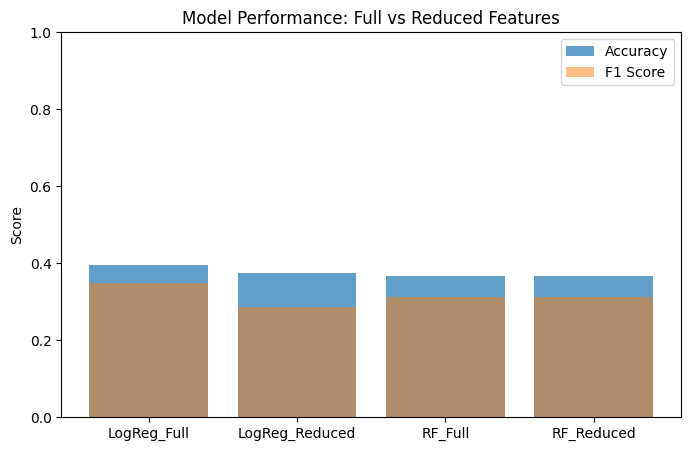

In [13]:
# --- 1. Define Final Reduced Feature Subset properly ---
# Numeric features
numeric_features = ['Age', 'Hours_Per_Week', 'Work_Life_Balance_Score', 'Social_Isolation_Score']

# Categorical features: include all one-hot columns of each selected categorical feature
mental_health_cols = [col for col in X.columns if 'Mental_Health_Status_' in col]
physical_health_cols = [col for col in X.columns if 'Physical_Health_Issues_' in col]
job_role_cols = [col for col in X.columns if 'Job_Role_' in col]
salary_cols = [col for col in X.columns if 'Salary_Range_' in col]

# Combine all into final reduced feature set
final_features = numeric_features + mental_health_cols + physical_health_cols + job_role_cols + salary_cols

print("Reduced features being used:")
for f in final_features:
    print("-", f)

# --- 2. Train/Test Split ---
from sklearn.model_selection import train_test_split
X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_red = X_train_full[final_features]
X_test_red = X_test_full[final_features]

# --- 3. Train Models & Evaluate ---
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt

# Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_full, y_train)
y_pred_lr_full = lr.predict(X_test_full)
lr.fit(X_train_red, y_train)
y_pred_lr_red = lr.predict(X_test_red)

# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_full, y_train)
y_pred_rf_full = rf.predict(X_test_full)
rf.fit(X_train_red, y_train)
y_pred_rf_red = rf.predict(X_test_red)

# Evaluate
results = pd.DataFrame({
    'Model': ['LogReg_Full','LogReg_Reduced','RF_Full','RF_Reduced'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr_full),
        accuracy_score(y_test, y_pred_lr_red),
        accuracy_score(y_test, y_pred_rf_full),
        accuracy_score(y_test, y_pred_rf_red)
    ],
    'F1_Score': [
        f1_score(y_test, y_pred_lr_full, average='weighted'),
        f1_score(y_test, y_pred_lr_red, average='weighted'),
        f1_score(y_test, y_pred_rf_full, average='weighted'),
        f1_score(y_test, y_pred_rf_red, average='weighted')
    ]
})

print("=== Model Performance Comparison ===")
print(results)

# Visualize
plt.figure(figsize=(8,5))
plt.bar(results['Model'], results['Accuracy'], alpha=0.7, label='Accuracy')
plt.bar(results['Model'], results['F1_Score'], alpha=0.5, label='F1 Score')
plt.title("Model Performance: Full vs Reduced Features")
plt.ylabel("Score")
plt.ylim(0,1)
plt.legend()
plt.show()
